In this notebook we will discuss about intermediate topics on lightning:
- Advanced dataloaders
- Model Callbacks
- LR Scheduler
- Common Debugging Techniques

In [1]:
%autosave 300
%autoreload 2
%reload_ext autoreload
%config Completer.use_jedi = False

Autosaving every 300 seconds


In [2]:
import os

os.chdir(
    "/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch"
)
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch


In [3]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [4]:
import os
from git import Repo
import pandas as pd
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch
import numpy as np
import torchvision.utils as vutils
import torch.nn.functional as F
import torchmetrics
import lightning as L
from torch.utils.data.dataset import random_split
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix
from lightning.pytorch.callbacks import (
    EarlyStopping,
    DeviceStatsMonitor,
    ModelCheckpoint,
)
from lightning.pytorch.tuner import Tuner
from pytorch_lightning.callbacks import ModelSummary

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(71)
AVAIL_GPUS = min(1, torch.cuda.device_count())
print(AVAIL_GPUS)

cuda
1


In [6]:
# data transformation
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize(32),
            transforms.RandomCrop((28, 28)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
    "test": transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    ),
}

Using Lightning to prepare the data

In [7]:
class MnistDataModule(L.LightningDataModule):
    def __init__(
        self,
        data_dir="./data",
        batch_size=128,
        transformers=data_transforms,
        num_workers=3,
    ):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transformers = transformers
        self.num_workers = num_workers

    def prepare_data(self) -> None:
        datasets.MNIST(root=self.data_dir, train=True, download=True)
        datasets.MNIST(root=self.data_dir, train=False, download=True)

    def setup(self, stage):
        self.mnist_test = datasets.MNIST(
            root=self.data_dir, train=False, transform=self.transformers["test"]
        )
        mnist_full = datasets.MNIST(
            root=self.data_dir, train=True, transform=self.transformers["train"]
        )
        self.mnist_train, self.mnist_val = random_split(
            mnist_full, [0.8, 0.2], generator=torch.Generator().manual_seed(71)
        )

    def train_dataloader(self):
        return DataLoader(
            self.mnist_train,
            batch_size=self.batch_size,
            shuffle=True,
            drop_last=True,
            num_workers=self.num_workers,
        )

    def val_dataloader(self):
        return DataLoader(
            self.mnist_val,
            batch_size=self.batch_size,
            shuffle=False,
            drop_last=False,
            num_workers=self.num_workers,
        )

    def test_dataloader(self):
        return DataLoader(
            self.mnist_test,
            batch_size=self.batch_size,
            shuffle=False,
            drop_last=False,
            num_workers=self.num_workers,
        )

    def predict_dataloader(self):
        return DataLoader(
            self.mnist_test,
            batch_size=self.batch_size,
            shuffle=False,
            drop_last=False,
            num_workers=self.num_workers,
        )

    def teardown(self, stage: str):
        # Used to clean-up when the run is finished
        ...

In [8]:
# data module
dm = MnistDataModule()

Model Definition and Lightning Trainer Module

In [9]:
class PyTorchMLP(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Linear(num_features, 50),
            torch.nn.ReLU(),
            # 2nd hidden layer
            torch.nn.Linear(50, 25),
            torch.nn.ReLU(),
            # output layer
            torch.nn.Linear(25, num_classes),
        )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        logits = self.all_layers(x)
        return logits

In [10]:
class PyTorchMLPLightning(L.LightningModule):
    def __init__(self, model, learning_rate):
        super(PyTorchMLPLightning, self).__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.criterion = torch.nn.CrossEntropyLoss()
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.save_hyperparameters(ignore=["model"])

    def forward(self, x: torch.Tensor):
        """
        Forward computation of the model
        """
        return self.model(x)

    def _shared_step(self, batch):
        """
        Shared step for training and validation
        """
        features, label = batch
        logits = self(features)
        loss = self.criterion(logits, label)
        predictions = torch.argmax(logits, dim=1)
        return label, loss, predictions

    def training_step(self, batch, batch_idx):
        """
        Training Step loss and metric calculation
        """

        label, loss, predictions = self._shared_step(batch)
        self.log(name="train_loss", value=loss, prog_bar=True)
        # metric calculation
        self.train_acc(predictions, label)
        self.log(
            name="train_acc",
            value=self.train_acc,
            prog_bar=True,
            on_epoch=True,
            on_step=False,
        )

        return loss

    def validation_step(self, batch, batch_idx):
        """
        Validation Step loss and metric calculation
        """

        label, loss, predictions = self._shared_step(batch)
        self.log(name="val_loss", value=loss, prog_bar=True)
        # metric calculation
        self.test_acc(predictions, label)
        self.log(
            name="val_acc",
            value=self.test_acc,
            prog_bar=True,
            on_epoch=True,
            on_step=False,
        )

    def test_step(self, batch, batch_idx):
        """
        Test step metric calculation
        """
        label, loss, predictions = self._shared_step(batch)
        # metric calculation
        self.test_acc(predictions, label)
        self.log(
            name="test_acc",
            value=self.test_acc,
            prog_bar=True,
            on_epoch=True,
            on_step=False,
        )

    def configure_optimizers(
        self,
    ):
        """
        Optimizer config
        """
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        return optimizer

In [11]:
# setting up the model
pytorch_model = PyTorchMLP(num_features=784, num_classes=10).to(device)
lightning_model = PyTorchMLPLightning(
    model=pytorch_model,
    learning_rate=0.05,
)

In [12]:
# # setting up the trainer module
# trainer = L.Trainer(
#     max_epochs=10,
#     accelerator="auto",
#     devices="auto",
#     enable_progress_bar=True,
#     enable_model_summary=True,
#     deterministic=True,
# )

In [13]:
# # fitting the model with custom datamodule
# trainer.fit(model=lightning_model, datamodule=dm)

In [14]:
# train_acc = trainer.validate(dataloaders=dm.train_dataloader())[0]["val_acc"]
# val_acc = trainer.validate(datamodule=dm)[0]["val_acc"]
# test_acc = trainer.test(datamodule=dm)[0]["test_acc"]
# print(
#     f"Train Acc {train_acc*100:.2f}%"
#     f" | Val Acc {val_acc*100:.2f}%"
#     f" | Test Acc {test_acc*100:.2f}%"
# )

Next we will discuss about logging mechanism other than tensorboard as tensorboard is not always feasible where as Csv logger is very slow

In [15]:
# setting up the trainer module
trainer = L.Trainer(
    max_epochs=10,
    accelerator="auto",
    devices="auto",
    enable_progress_bar=True,
    enable_model_summary=True,
    logger=CSVLogger(save_dir="./logs", name="Mnist_exp"),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [16]:
# fitting the model with custom datamodule
trainer.fit(model=lightning_model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | PyTorchMLP         | 40.8 K
1 | criterion | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
40.8 K    Trainable params
0         Non-trainable params
40.8 K    Total params
0.163     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=10` reached.


In [17]:
train_acc = trainer.validate(dataloaders=dm.train_dataloader())[0]["val_acc"]
val_acc = trainer.validate(datamodule=dm)[0]["val_acc"]
test_acc = trainer.test(datamodule=dm)[0]["test_acc"]
print(
    f"Train Acc {train_acc*100:.2f}%"
    f" | Val Acc {val_acc*100:.2f}%"
    f" | Test Acc {test_acc*100:.2f}%"
)

/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.validate(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.validate(ckpt_path='best')` to use the best model or `.validate(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at ./logs/Mnist_exp/version_17/checkpoints/epoch=9-step=620.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./logs/Mnist_exp/version_17/checkpoints/epoch=9-step=620.ckpt
/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Validation: |                                                                                                 …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.7719253897666931     │
│         val_loss          │    0.6846393346786499     │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at ./logs/Mnist_exp/version_17/checkpoints/epoch=9-step=620.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./logs/Mnist_exp/version_17/checkpoints/epoch=9-step=620.ckpt


Validation: |                                                                                                 …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.7789999842643738     │
│         val_loss          │    0.7034180760383606     │
└───────────────────────────┴───────────────────────────┘

/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at ./logs/Mnist_exp/version_17/checkpoints/epoch=9-step=620.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./logs/Mnist_exp/version_17/checkpoints/epoch=9-step=620.ckpt


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6237999796867371     │
└───────────────────────────┴───────────────────────────┘

Train Acc 77.19% | Val Acc 77.90% | Test Acc 62.38%


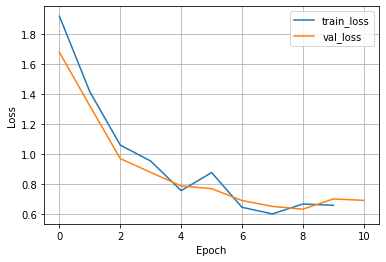

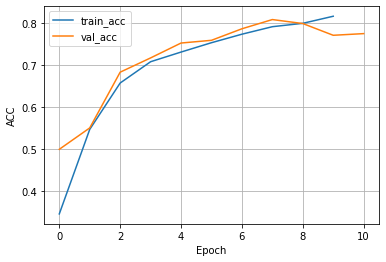

In [18]:
# Plotting the metrics
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)
df_metrics[["train_acc", "val_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)

plt.show()

Other metrics on real test data

/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


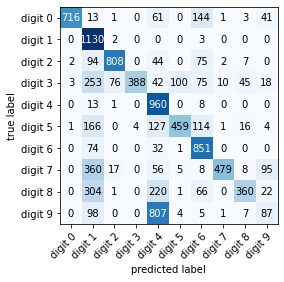

In [19]:
class_dict = {
    0: "digit 0",
    1: "digit 1",
    2: "digit 2",
    3: "digit 3",
    4: "digit 4",
    5: "digit 5",
    6: "digit 6",
    7: "digit 7",
    8: "digit 8",
    9: "digit 9",
}
cmat = ConfusionMatrix(task="multiclass", num_classes=len(class_dict))

for x, y in dm.test_dataloader():

    with torch.inference_mode():
        pred = lightning_model(x)
    cmat(pred, y)

cmat_tensor = cmat.compute()
cmat = cmat_tensor.numpy()

fig, ax = plot_confusion_matrix(
    conf_mat=cmat,
    class_names=class_dict.values(),
)
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.show()

Next is the Application of Most commonly used callbacks like  Model Checkpoint and Early stopping and Device Monitor

In [28]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=True, mode="min")
device_monitor = DeviceStatsMonitor()
model_checkpoint = ModelCheckpoint(
    dirpath="./models",
    monitor="val_loss",
    mode="min",
    verbose=True,
    save_top_k=1,
)

Re-Run the entire model flow but now with callbacks

In [29]:
# setting up the model
pytorch_model = PyTorchMLP(num_features=784, num_classes=10).to(device)
lightning_model = PyTorchMLPLightning(
    model=pytorch_model,
    learning_rate=0.05,
)

In [30]:
# setting up the trainer module
trainer = L.Trainer(
    max_epochs=10,
    accelerator="auto",
    devices="auto",
    enable_progress_bar=True,
    enable_model_summary=True,
    logger=CSVLogger(save_dir="./logs", name="Mnist_exp"),
    callbacks=[device_monitor, early_stopping, model_checkpoint],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [31]:
# fitting the model with custom datamodule
trainer.fit(model=lightning_model, datamodule=dm)

/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | PyTorchMLP         | 40.8 K
1 | criterion | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
40.8 K    Trainable params
0         Non-trainable params
40.8 K    Total params
0.163     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |                                                                                                   …

/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |                                                                                                 …

Metric val_loss improved. New best score: 1.705
Epoch 0, global step 62: 'val_loss' reached 1.70505 (best 1.70505), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=0-step=62.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.485 >= min_delta = 0.0. New best score: 1.220
Epoch 1, global step 124: 'val_loss' reached 1.21974 (best 1.21974), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=1-step=124.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.314 >= min_delta = 0.0. New best score: 0.906
Epoch 2, global step 186: 'val_loss' reached 0.90621 (best 0.90621), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=2-step=186.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.880
Epoch 3, global step 248: 'val_loss' reached 0.88041 (best 0.88041), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=3-step=248.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 0.849
Epoch 4, global step 310: 'val_loss' reached 0.84862 (best 0.84862), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=4-step=310.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.083 >= min_delta = 0.0. New best score: 0.765
Epoch 5, global step 372: 'val_loss' reached 0.76516 (best 0.76516), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=5-step=372.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.096 >= min_delta = 0.0. New best score: 0.669
Epoch 6, global step 434: 'val_loss' reached 0.66931 (best 0.66931), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=6-step=434.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 0.619
Epoch 7, global step 496: 'val_loss' reached 0.61853 (best 0.61853), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=7-step=496.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 8, global step 558: 'val_loss' was not in top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.082 >= min_delta = 0.0. New best score: 0.537
Epoch 9, global step 620: 'val_loss' reached 0.53661 (best 0.53661), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=9-step=620-v2.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


In [32]:
val_acc = trainer.validate(datamodule=dm, ckpt_path="best")[0]["val_acc"]
test_acc = trainer.test(datamodule=dm, ckpt_path="best")[0]["test_acc"]
print(
    f" | Val Acc {val_acc*100:.2f}%"
    f" | Test Acc {test_acc*100:.2f}%"
)

Restoring states from the checkpoint path at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=9-step=620-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=9-step=620-v2.ckpt


Validation: |                                                                                                 …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8305000066757202     │
│         val_loss          │    0.5466420650482178     │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=9-step=620-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=9-step=620-v2.ckpt


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8240000009536743     │
└───────────────────────────┴───────────────────────────┘

 | Val Acc 83.05% | Test Acc 82.40%


Load the pre trained model and test it again

In [33]:
path = trainer.checkpoint_callback.best_model_path

lightning_model = PyTorchMLPLightning.load_from_checkpoint(
    path, learning_rate=0.05, model=pytorch_model
)
lightning_model.eval()

trainer.test(model=lightning_model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8240000009536743     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8240000009536743}]

Next we will discuss LR scheduler

get the best LR using LR finder and without any callback

In [34]:
# setting up the model
pytorch_model = PyTorchMLP(num_features=784, num_classes=10).to(device)
lightning_model = PyTorchMLPLightning(
    model=pytorch_model,
    learning_rate=0.05,
)

In [35]:
# setting up the trainer module
trainer = L.Trainer(
    max_epochs=10,
    accelerator="auto",
    devices="auto",
    enable_progress_bar=True,
    enable_model_summary=True,
    logger=CSVLogger(save_dir="./logs", name="Mnist_exp"),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [36]:
tuner = Tuner(trainer=trainer)

In [37]:
lr_finder = tuner.lr_find(lightning_model, datamodule=dm, num_training=100, max_lr=0.1)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.08511380382023763
Restoring states from the checkpoint path at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/.lr_find_9053a794-44fc-46e3-98a5-d5c636015067.ckpt
Restored all states from the checkpoint at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/.lr_find_9053a794-44fc-46e3-98a5-d5c636015067.ckpt


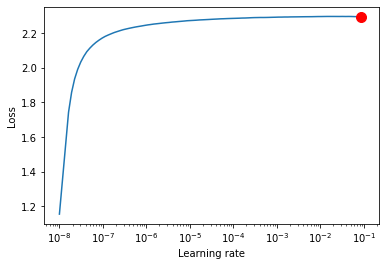

In [38]:
fig = lr_finder.plot(suggest=True)

In [39]:
# get suggestion
new_lr = lr_finder.suggestion()
print(new_lr)

0.08511380382023763


In [40]:
# update hparams of the model
lightning_model.learning_rate = new_lr

In [41]:
trainer.fit(model=lightning_model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | PyTorchMLP         | 40.8 K
1 | criterion | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
40.8 K    Trainable params
0         Non-trainable params
40.8 K    Total params
0.163     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=10` reached.


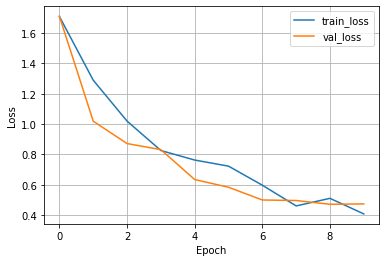

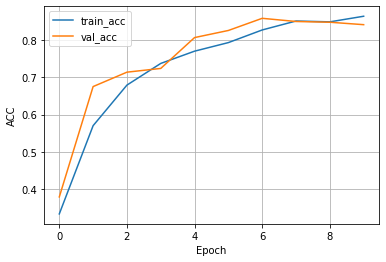

In [42]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)


df_metrics[["train_acc", "val_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)


plt.show()

In [43]:
val_acc = trainer.validate(datamodule=dm, ckpt_path="best")[0]["val_acc"]
test_acc = trainer.test(datamodule=dm, ckpt_path="best")[0]["test_acc"]
print(
    f" | Val Acc {val_acc*100:.2f}%"
    f" | Test Acc {test_acc*100:.2f}%"
)

Restoring states from the checkpoint path at ./logs/Mnist_exp/version_19/checkpoints/epoch=9-step=620.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./logs/Mnist_exp/version_19/checkpoints/epoch=9-step=620.ckpt
/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |                                                                                                 …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8479999899864197     │
│         val_loss          │    0.4819379150867462     │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at ./logs/Mnist_exp/version_19/checkpoints/epoch=9-step=620.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./logs/Mnist_exp/version_19/checkpoints/epoch=9-step=620.ckpt


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7904000282287598     │
└───────────────────────────┴───────────────────────────┘

 | Val Acc 84.80% | Test Acc 79.04%


Application of LR schedulers to Improve the model performance
Add the scheduler under method - configure_optimizer in the Lightning Module code

In [44]:
class PyTorchMLPLightning(L.LightningModule):
    def __init__(self, model, learning_rate):
        super(PyTorchMLPLightning, self).__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.criterion = torch.nn.CrossEntropyLoss()
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.save_hyperparameters(ignore=["model"])

    def forward(self, x: torch.Tensor):
        """
        Forward computation of the model
        """
        return self.model(x)

    def _shared_step(self, batch):
        """
        Shared step for training and validation
        """
        features, label = batch
        logits = self(features)
        loss = self.criterion(logits, label)
        predictions = torch.argmax(logits, dim=1)
        return label, loss, predictions

    def training_step(self, batch, batch_idx):
        """
        Training Step loss and metric calculation
        """

        label, loss, predictions = self._shared_step(batch)
        self.log(name="train_loss", value=loss, prog_bar=True)
        # metric calculation
        self.train_acc(predictions, label)
        self.log(
            name="train_acc",
            value=self.train_acc,
            prog_bar=True,
            on_epoch=True,
            on_step=False,
        )

        return loss

    def validation_step(self, batch, batch_idx):
        """
        Validation Step loss and metric calculation
        """

        label, loss, predictions = self._shared_step(batch)
        self.log(name="val_loss", value=loss, prog_bar=True)
        # metric calculation
        self.test_acc(predictions, label)
        self.log(
            name="val_acc",
            value=self.test_acc,
            prog_bar=True,
            on_epoch=True,
            on_step=False,
        )

    def test_step(self, batch, batch_idx):
        """
        Test step metric calculation
        """
        label, loss, predictions = self._shared_step(batch)
        # metric calculation
        self.test_acc(predictions, label)
        self.log(
            name="test_acc",
            value=self.test_acc,
            prog_bar=True,
            on_epoch=True,
            on_step=False,
        )

    def configure_optimizers(
        self,
    ):
        """
        Optimizer config
        """
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, step_size=5, gamma=0.7, verbose=True
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
            },
        }

In [45]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=True, mode="min")
device_monitor = DeviceStatsMonitor()
model_checkpoint = ModelCheckpoint(
    dirpath="./models",
    monitor="val_loss",
    mode="min",
    verbose=True,
    save_top_k=1,
)

In [46]:
# setting up the model
pytorch_model = PyTorchMLP(num_features=784, num_classes=10).to(device)
lightning_model = PyTorchMLPLightning(
    model=pytorch_model,
    learning_rate=new_lr,
)
# setting up the trainer module
trainer = L.Trainer(
    max_epochs=25,
    accelerator="auto",
    devices="auto",
    enable_progress_bar=True,
    enable_model_summary=True,
    logger=CSVLogger(save_dir="./logs", name="Mnist_exp"),
    callbacks=[early_stopping, model_checkpoint],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [47]:
L.seed_everything(123)
trainer.fit(model=lightning_model, datamodule=dm)

Seed set to 123
/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/azureuser/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | PyTorchMLP         | 40.8 K
1 | criterion | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
40.8 K    Trainable params
0         Non-trainable params
40.8 K

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Metric val_loss improved. New best score: 1.565
Epoch 0, global step 62: 'val_loss' reached 1.56471 (best 1.56471), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=0-step=62.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.226 >= min_delta = 0.0. New best score: 1.338
Epoch 1, global step 124: 'val_loss' reached 1.33846 (best 1.33846), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=1-step=124.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.494 >= min_delta = 0.0. New best score: 0.844
Epoch 2, global step 186: 'val_loss' reached 0.84426 (best 0.84426), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=2-step=186.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 3, global step 248: 'val_loss' was not in top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.154 >= min_delta = 0.0. New best score: 0.690
Epoch 4, global step 310: 'val_loss' reached 0.68999 (best 0.68999), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=4-step=310.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.109 >= min_delta = 0.0. New best score: 0.581
Epoch 5, global step 372: 'val_loss' reached 0.58138 (best 0.58138), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=5-step=372.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.543
Epoch 6, global step 434: 'val_loss' reached 0.54338 (best 0.54338), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=6-step=434.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.069 >= min_delta = 0.0. New best score: 0.474
Epoch 7, global step 496: 'val_loss' reached 0.47397 (best 0.47397), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=7-step=496.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 8, global step 558: 'val_loss' was not in top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.436
Epoch 9, global step 620: 'val_loss' reached 0.43596 (best 0.43596), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=9-step=620-v3.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.423
Epoch 10, global step 682: 'val_loss' reached 0.42280 (best 0.42280), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=10-step=682.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.405
Epoch 11, global step 744: 'val_loss' reached 0.40453 (best 0.40453), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=11-step=744.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.377
Epoch 12, global step 806: 'val_loss' reached 0.37720 (best 0.37720), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=12-step=806.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 13, global step 868: 'val_loss' was not in top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 0.335
Epoch 14, global step 930: 'val_loss' reached 0.33537 (best 0.33537), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=14-step=930.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 15, global step 992: 'val_loss' was not in top 1


Validation: |                                                                                                 …

Epoch 16, global step 1054: 'val_loss' was not in top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.324
Epoch 17, global step 1116: 'val_loss' reached 0.32449 (best 0.32449), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=17-step=1116.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.311
Epoch 18, global step 1178: 'val_loss' reached 0.31061 (best 0.31061), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=18-step=1178.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 19, global step 1240: 'val_loss' was not in top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.292
Epoch 20, global step 1302: 'val_loss' reached 0.29206 (best 0.29206), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=20-step=1302-v1.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 21, global step 1364: 'val_loss' was not in top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.287
Epoch 22, global step 1426: 'val_loss' reached 0.28661 (best 0.28661), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=22-step=1426-v1.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 23, global step 1488: 'val_loss' was not in top 1


Validation: |                                                                                                 …

Epoch 24, global step 1550: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=25` reached.


In [48]:
val_acc = trainer.validate(datamodule=dm, ckpt_path="best")[0]["val_acc"]
test_acc = trainer.test(datamodule=dm, ckpt_path="best")[0]["test_acc"]
print(f" | Val Acc {val_acc*100:.2f}%" f" | Test Acc {test_acc*100:.2f}%")

Restoring states from the checkpoint path at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=22-step=1426-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=22-step=1426-v1.ckpt


Validation: |                                                                                                 …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9139999747276306     │
│         val_loss          │    0.29643017053604126    │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=22-step=1426-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=22-step=1426-v1.ckpt


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8884999752044678     │
└───────────────────────────┴───────────────────────────┘

 | Val Acc 91.40% | Test Acc 88.85%


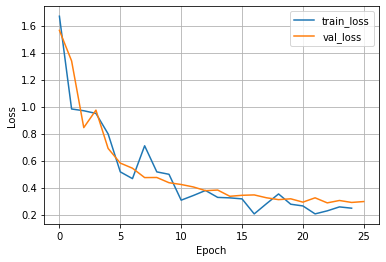

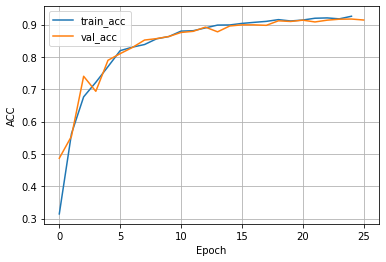

In [49]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)


df_metrics[["train_acc", "val_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)


plt.show()

Aplication of ReduceLROnPlateau

In [50]:
class PyTorchMLPLightning(L.LightningModule):
    def __init__(self, model, learning_rate):
        super(PyTorchMLPLightning, self).__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.criterion = torch.nn.CrossEntropyLoss()
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.save_hyperparameters(ignore=["model"])

    def forward(self, x: torch.Tensor):
        """
        Forward computation of the model
        """
        return self.model(x)

    def _shared_step(self, batch):
        """
        Shared step for training and validation
        """
        features, label = batch
        logits = self(features)
        loss = self.criterion(logits, label)
        predictions = torch.argmax(logits, dim=1)
        return label, loss, predictions

    def training_step(self, batch, batch_idx):
        """
        Training Step loss and metric calculation
        """

        label, loss, predictions = self._shared_step(batch)
        self.log(name="train_loss", value=loss, prog_bar=True)
        # metric calculation
        self.train_acc(predictions, label)
        self.log(
            name="train_acc",
            value=self.train_acc,
            prog_bar=True,
            on_epoch=True,
            on_step=False,
        )

        return loss

    def validation_step(self, batch, batch_idx):
        """
        Validation Step loss and metric calculation
        """

        label, loss, predictions = self._shared_step(batch)
        self.log(name="val_loss", value=loss, prog_bar=True)
        # metric calculation
        self.test_acc(predictions, label)
        self.log(
            name="val_acc",
            value=self.test_acc,
            prog_bar=True,
            on_epoch=True,
            on_step=False,
        )

    def test_step(self, batch, batch_idx):
        """
        Test step metric calculation
        """
        label, loss, predictions = self._shared_step(batch)
        # metric calculation
        self.test_acc(predictions, label)
        self.log(
            name="test_acc",
            value=self.test_acc,
            prog_bar=True,
            on_epoch=True,
            on_step=False,
        )

    def configure_optimizers(
        self,
    ):
        """
        Optimizer config
        """
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=0.1, patience=5
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
            },
        }

In [51]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=True, mode="min")
device_monitor = DeviceStatsMonitor()
model_checkpoint = ModelCheckpoint(
    dirpath="./models",
    monitor="val_loss",
    mode="min",
    verbose=True,
    save_top_k=1,
)

In [52]:
# setting up the model
pytorch_model = PyTorchMLP(num_features=784, num_classes=10).to(device)
lightning_model = PyTorchMLPLightning(
    model=pytorch_model,
    learning_rate=new_lr,
)
# setting up the trainer module
trainer = L.Trainer(
    max_epochs=25,
    accelerator="auto",
    devices="auto",
    enable_progress_bar=True,
    enable_model_summary=True,
    logger=CSVLogger(save_dir="./logs", name="Mnist_exp"),
    callbacks=[early_stopping, model_checkpoint],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [53]:
L.seed_everything(123)
trainer.fit(model=lightning_model, datamodule=dm)

Seed set to 123
/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | PyTorchMLP         | 40.8 K
1 | criterion | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
40.8 K    Trainable params
0         Non-trainable params
40.8 K    Total params
0.163     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |                                                                                                   …

Validation: |                                                                                                 …

Metric val_loss improved. New best score: 1.377
Epoch 0, global step 62: 'val_loss' reached 1.37724 (best 1.37724), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=0-step=62.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.273 >= min_delta = 0.0. New best score: 1.104
Epoch 1, global step 124: 'val_loss' reached 1.10430 (best 1.10430), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=1-step=124.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.201 >= min_delta = 0.0. New best score: 0.903
Epoch 2, global step 186: 'val_loss' reached 0.90286 (best 0.90286), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=2-step=186.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 3, global step 248: 'val_loss' was not in top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.183 >= min_delta = 0.0. New best score: 0.720
Epoch 4, global step 310: 'val_loss' reached 0.71970 (best 0.71970), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=4-step=310.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.071 >= min_delta = 0.0. New best score: 0.648
Epoch 5, global step 372: 'val_loss' reached 0.64834 (best 0.64834), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=5-step=372.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 6, global step 434: 'val_loss' was not in top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.112 >= min_delta = 0.0. New best score: 0.537
Epoch 7, global step 496: 'val_loss' reached 0.53680 (best 0.53680), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=7-step=496.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.526
Epoch 8, global step 558: 'val_loss' reached 0.52647 (best 0.52647), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=8-step=558.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.082 >= min_delta = 0.0. New best score: 0.445
Epoch 9, global step 620: 'val_loss' reached 0.44479 (best 0.44479), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=9-step=620-v3.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.422
Epoch 10, global step 682: 'val_loss' reached 0.42188 (best 0.42188), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=10-step=682.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 11, global step 744: 'val_loss' was not in top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.071 >= min_delta = 0.0. New best score: 0.351
Epoch 12, global step 806: 'val_loss' reached 0.35095 (best 0.35095), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=12-step=806.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.347
Epoch 13, global step 868: 'val_loss' reached 0.34684 (best 0.34684), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=13-step=868.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.332
Epoch 14, global step 930: 'val_loss' reached 0.33214 (best 0.33214), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=14-step=930.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 15, global step 992: 'val_loss' was not in top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.328
Epoch 16, global step 1054: 'val_loss' reached 0.32762 (best 0.32762), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=16-step=1054.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.319
Epoch 17, global step 1116: 'val_loss' reached 0.31872 (best 0.31872), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=17-step=1116.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.291
Epoch 18, global step 1178: 'val_loss' reached 0.29144 (best 0.29144), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=18-step=1178.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 19, global step 1240: 'val_loss' was not in top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.253
Epoch 20, global step 1302: 'val_loss' reached 0.25310 (best 0.25310), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=20-step=1302-v1.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 21, global step 1364: 'val_loss' was not in top 1


Validation: |                                                                                                 …

Epoch 22, global step 1426: 'val_loss' was not in top 1


Validation: |                                                                                                 …

Epoch 23, global step 1488: 'val_loss' was not in top 1


Validation: |                                                                                                 …

Epoch 24, global step 1550: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=25` reached.


In [54]:
val_acc = trainer.validate(datamodule=dm, ckpt_path="best")[0]["val_acc"]
test_acc = trainer.test(datamodule=dm, ckpt_path="best")[0]["test_acc"]
print(f" | Val Acc {val_acc*100:.2f}%" f" | Test Acc {test_acc*100:.2f}%")

Restoring states from the checkpoint path at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=20-step=1302-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=20-step=1302-v1.ckpt


Validation: |                                                                                                 …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9235000014305115     │
│         val_loss          │    0.2583066523075104     │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=20-step=1302-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=20-step=1302-v1.ckpt


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.925000011920929     │
└───────────────────────────┴───────────────────────────┘

 | Val Acc 92.35% | Test Acc 92.50%


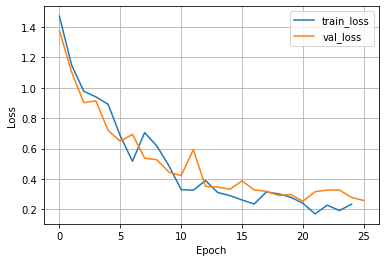

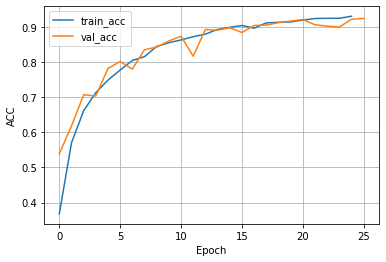

In [55]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)


df_metrics[["train_acc", "val_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)


plt.show()

Addition of Dropout and BatchNorm before activation in the original model to handle overfiting

In [56]:
class PyTorchMLP(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Linear(num_features, 50),
            torch.nn.BatchNorm1d(50),
            torch.nn.Dropout(0.2),
            torch.nn.ReLU(),
            # 2nd hidden layer
            torch.nn.Linear(50, 25),
            torch.nn.BatchNorm1d(25),
            torch.nn.Dropout(0.2),
            torch.nn.ReLU(),
            # output layer
            torch.nn.Linear(25, num_classes),
        )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        logits = self.all_layers(x)
        return logits

In [57]:
class PyTorchMLPLightning(L.LightningModule):
    def __init__(self, model, learning_rate):
        super(PyTorchMLPLightning, self).__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.criterion = torch.nn.CrossEntropyLoss()
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.save_hyperparameters(ignore=["model"])

    def forward(self, x: torch.Tensor):
        """
        Forward computation of the model
        """
        return self.model(x)

    def _shared_step(self, batch):
        """
        Shared step for training and validation
        """
        features, label = batch
        logits = self(features)
        loss = self.criterion(logits, label)
        predictions = torch.argmax(logits, dim=1)
        return label, loss, predictions

    def training_step(self, batch, batch_idx):
        """
        Training Step loss and metric calculation
        """

        label, loss, predictions = self._shared_step(batch)
        self.log(name="train_loss", value=loss, prog_bar=True)
        # metric calculation
        self.train_acc(predictions, label)
        self.log(
            name="train_acc",
            value=self.train_acc,
            prog_bar=True,
            on_epoch=True,
            on_step=False,
        )

        return loss

    def validation_step(self, batch, batch_idx):
        """
        Validation Step loss and metric calculation
        """

        label, loss, predictions = self._shared_step(batch)
        self.log(name="val_loss", value=loss, prog_bar=True)
        # metric calculation
        self.test_acc(predictions, label)
        self.log(
            name="val_acc",
            value=self.test_acc,
            prog_bar=True,
            on_epoch=True,
            on_step=False,
        )

    def test_step(self, batch, batch_idx):
        """
        Test step metric calculation
        """
        label, loss, predictions = self._shared_step(batch)
        # metric calculation
        self.test_acc(predictions, label)
        self.log(
            name="test_acc",
            value=self.test_acc,
            prog_bar=True,
            on_epoch=True,
            on_step=False,
        )

    def configure_optimizers(
        self,
    ):
        """
        Optimizer config
        """
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, step_size=5, gamma=0.7, verbose=True
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
            },
        }

In [58]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=True, mode="min")
device_monitor = DeviceStatsMonitor()
model_checkpoint = ModelCheckpoint(
    dirpath="./models",
    monitor="val_loss",
    mode="min",
    verbose=True,
    save_top_k=1,
)

In [59]:
# setting up the model
pytorch_model = PyTorchMLP(num_features=784, num_classes=10).to(device)
lightning_model = PyTorchMLPLightning(
    model=pytorch_model,
    learning_rate=new_lr,
)
# setting up the trainer module
trainer = L.Trainer(
    max_epochs=25,
    accelerator="auto",
    devices="auto",
    enable_progress_bar=True,
    enable_model_summary=True,
    logger=CSVLogger(save_dir="./logs", name="Mnist_exp"),
    callbacks=[early_stopping, model_checkpoint],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [60]:
L.seed_everything(123)
trainer.fit(model=lightning_model, datamodule=dm)

Seed set to 123
/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/azureuser/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | PyTorchMLP         | 40.9 K
1 | criterion | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
40.9 K    Trainable params
0         Non-trainable params
40.9 K

Sanity Checking: |                                                                                            …

/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |                                                                                                   …

/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |                                                                                                 …

Metric val_loss improved. New best score: 1.003
Epoch 0, global step 62: 'val_loss' reached 1.00253 (best 1.00253), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=0-step=62.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.297 >= min_delta = 0.0. New best score: 0.705
Epoch 1, global step 124: 'val_loss' reached 0.70537 (best 0.70537), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=1-step=124.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.128 >= min_delta = 0.0. New best score: 0.578
Epoch 2, global step 186: 'val_loss' reached 0.57761 (best 0.57761), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=2-step=186.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.103 >= min_delta = 0.0. New best score: 0.475
Epoch 3, global step 248: 'val_loss' reached 0.47493 (best 0.47493), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=3-step=248.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 0.427
Epoch 4, global step 310: 'val_loss' reached 0.42659 (best 0.42659), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=4-step=310.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.392
Epoch 5, global step 372: 'val_loss' reached 0.39174 (best 0.39174), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=5-step=372.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.391
Epoch 6, global step 434: 'val_loss' reached 0.39075 (best 0.39075), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=6-step=434.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 0.343
Epoch 7, global step 496: 'val_loss' reached 0.34250 (best 0.34250), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=7-step=496.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.321
Epoch 8, global step 558: 'val_loss' reached 0.32051 (best 0.32051), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=8-step=558.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.317
Epoch 9, global step 620: 'val_loss' reached 0.31723 (best 0.31723), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=9-step=620-v3.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.304
Epoch 10, global step 682: 'val_loss' reached 0.30411 (best 0.30411), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=10-step=682.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.289
Epoch 11, global step 744: 'val_loss' reached 0.28937 (best 0.28937), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=11-step=744.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.274
Epoch 12, global step 806: 'val_loss' reached 0.27384 (best 0.27384), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=12-step=806.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 13, global step 868: 'val_loss' was not in top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.269
Epoch 14, global step 930: 'val_loss' reached 0.26901 (best 0.26901), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=14-step=930.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.259
Epoch 15, global step 992: 'val_loss' reached 0.25886 (best 0.25886), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=15-step=992.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.255
Epoch 16, global step 1054: 'val_loss' reached 0.25524 (best 0.25524), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=16-step=1054.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 17, global step 1116: 'val_loss' was not in top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.245
Epoch 18, global step 1178: 'val_loss' reached 0.24519 (best 0.24519), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=18-step=1178.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 19, global step 1240: 'val_loss' was not in top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.244
Epoch 20, global step 1302: 'val_loss' reached 0.24449 (best 0.24449), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=20-step=1302-v2.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 21, global step 1364: 'val_loss' was not in top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.236
Epoch 22, global step 1426: 'val_loss' reached 0.23573 (best 0.23573), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=22-step=1426-v2.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.236
Epoch 23, global step 1488: 'val_loss' reached 0.23555 (best 0.23555), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=23-step=1488-v2.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.219
Epoch 24, global step 1550: 'val_loss' reached 0.21920 (best 0.21920), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=24-step=1550-v2.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=25` reached.


In [61]:
val_acc = trainer.validate(datamodule=dm, ckpt_path="best")[0]["val_acc"]
test_acc = trainer.test(datamodule=dm, ckpt_path="best")[0]["test_acc"]
print(f" | Val Acc {val_acc*100:.2f}%" f" | Test Acc {test_acc*100:.2f}%")

Restoring states from the checkpoint path at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=24-step=1550-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=24-step=1550-v2.ckpt


Validation: |                                                                                                 …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9340000152587891     │
│         val_loss          │    0.2293919026851654     │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=24-step=1550-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=24-step=1550-v2.ckpt


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8657000064849854     │
└───────────────────────────┴───────────────────────────┘

 | Val Acc 93.40% | Test Acc 86.57%


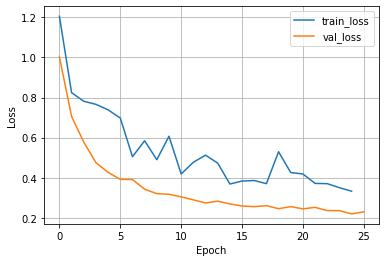

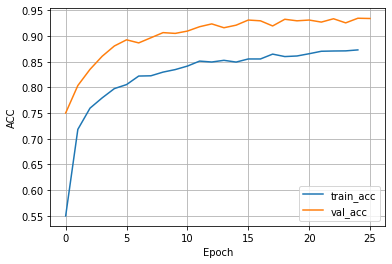

In [62]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)


df_metrics[["train_acc", "val_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)


plt.show()

Debugging Steps

Fast Dev run for quick prototyping

In [63]:
L.seed_everything(123)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=True, mode="min")
model_checkpoint = ModelCheckpoint(
    dirpath="./models",
    monitor="val_loss",
    mode="min",
    verbose=True,
    save_top_k=1,
)
# setting up the model
pytorch_model = PyTorchMLP(num_features=784, num_classes=10).to(device)
lightning_model = PyTorchMLPLightning(
    model=pytorch_model,
    learning_rate=new_lr,
)
# setting up the trainer module
trainer = L.Trainer(
    fast_dev_run=5,  # Runs n if set to n (int) else 1 if set to True batch(es) of train, val and test to find any bugs
    accelerator="auto",
    devices="auto",
    enable_progress_bar=True,
    enable_model_summary=True,
    logger=CSVLogger(save_dir="./logs", name="Mnist_exp"),
    callbacks=[early_stopping, model_checkpoint],
)
trainer.fit(model=lightning_model, datamodule=dm)

Seed set to 123
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 5 batch(es). Logging and checkpointing is suppressed.
/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/azureuser/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | Py

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=5` reached.


Batch Overfitting to show high train acc in case of small batch

In [64]:
L.seed_everything(123)
# setting up the model
pytorch_model = PyTorchMLP(num_features=784, num_classes=10).to(device)
lightning_model = PyTorchMLPLightning(
    model=pytorch_model,
    learning_rate=new_lr,
)
# setting up the trainer module
trainer = L.Trainer(
    overfit_batches=1,
    max_epochs=10,
    accelerator="auto",
    devices="auto",
    enable_progress_bar=True,
    enable_model_summary=True,
    logger=CSVLogger(save_dir="./logs", name="Mnist_exp"),
)
trainer.fit(model=lightning_model, datamodule=dm)

Seed set to 123
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | PyTorchMLP         | 40.9 K
1 | criterion | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
40.9 K    Trainable params
0         Non-trainable params
40.9 K    Total params
0.164     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:268: You requested to overfit but enabled train dataloader shuffling. We are turning off the train dataloader shuffling for you.
/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=10` reached.


#######################----------------------------------------------------------------####################################